In [80]:
import numpy as np
import pandas as pd

import anndata

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

def nd(matrix):
    return(np.array(matrix).flatten())

In [8]:
samples = ["S0","S1","S10",
           "S14","S15","S17",
           "S2","S22","S23",
           "S26","S3","S35",
           "S37","S38","S40",
           "S8","S9"]

metadata = pd.read_csv('./data/lu_radiation/GSE165318_meta.data.single.cell.csv')

In [36]:
for group in metadata['Group'].unique():
    print(group)
    for s in samples:
        group_ = metadata[metadata['sample']==s]['Group'].unique()[0]
        if group_ == group:
            print(s)

T0
S0
S22
S23
S26
T1
S1
S2
S3
S35
T3
S10
S8
S9
T7
S14
S15
S17
T14
S37
S38
S40


In [39]:
sample_order = ['S0',
    'S22',
    'S23',
    'S26',
    'S1',
    'S2',
    'S3',
    'S35',
    'S10',
    'S8',
    'S9',
    'S14',
    'S15',
    'S17',
    'S37',
    'S38',
    'S40']

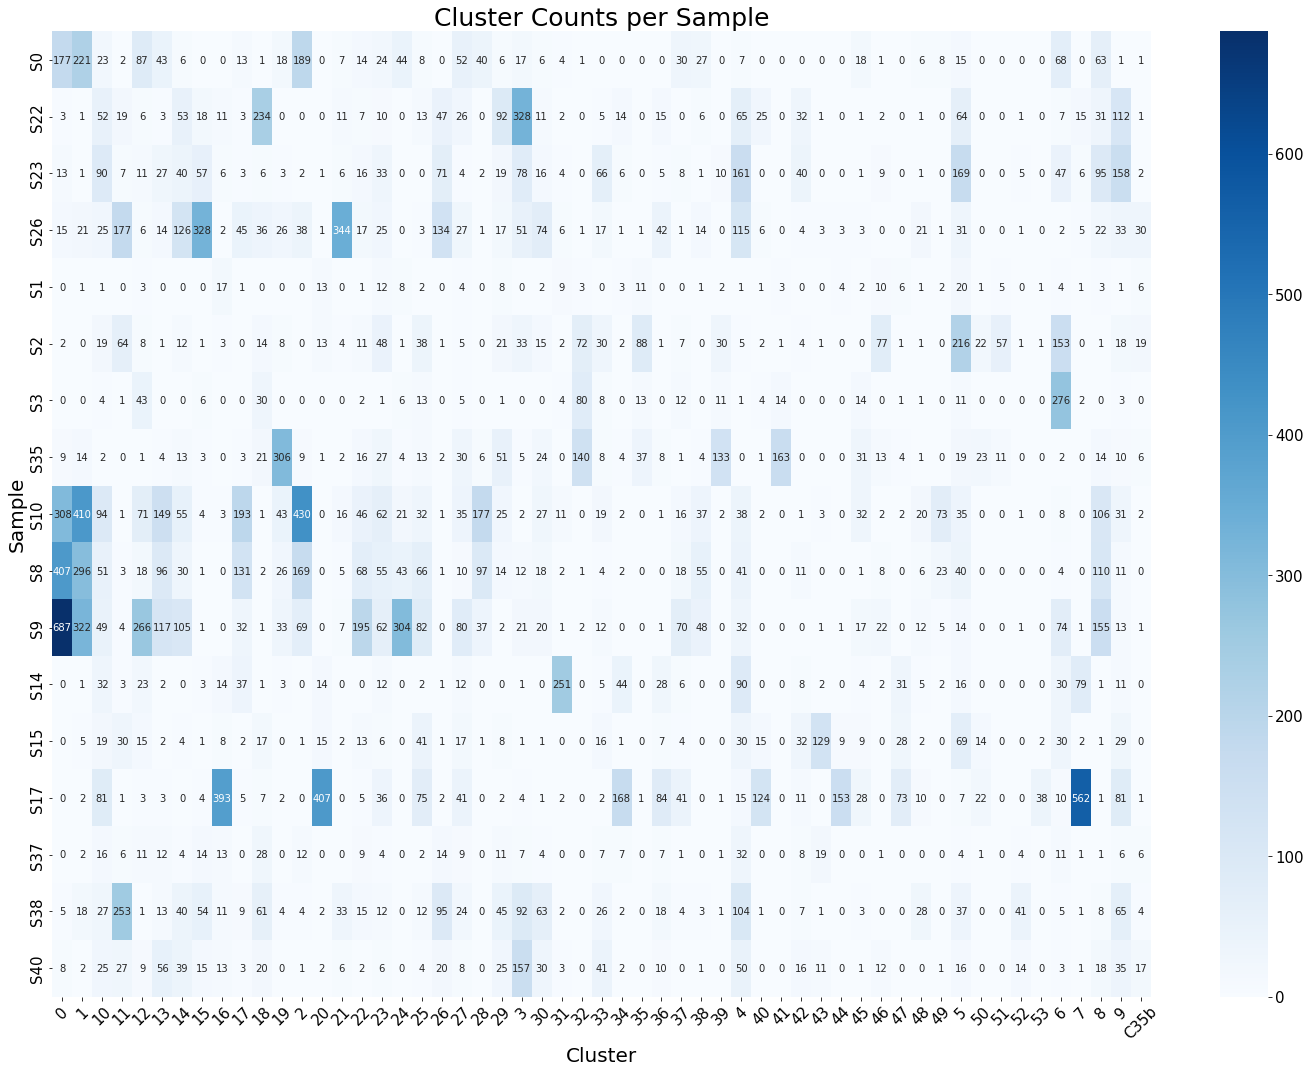

In [65]:
# how many cells and cell type per sample, grouped by day
sample_cluster_counts = metadata.groupby(['sample', 'Cluster']).size().reset_index(name='count')

# pivot data for heatmap
heatmap_data = sample_cluster_counts.pivot(index='sample', columns='Cluster', values='count').fillna(0)

# Create the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_data.loc[sample_order], annot=True, fmt='.0f', cmap='Blues')

# Set labels
plt.xlabel('Cluster',fontsize=20)
plt.ylabel('Sample',fontsize=20)
plt.title('Cluster Counts per Sample',fontsize=25)
plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

In [60]:
# let us now aggregate by celltype
cluster2celltype_dict = {
    'Enterocyte': ['5','7','15','18','20','29','31','32','33','40','41','43','46','47','49','52'], 
    'Stem': ['4','9','16','28','35','C35b'],
    'TA': ['44'],
    'T': ['1','2','3','8','11','17','19','21','30','53'],
    'B': ['13','14','26','50'],
    'Myeloid': ['0','22','24','36','38'],
    'Stromal': ['6','27','37'],
    'Endothelial': ['12','25'],
    'Goblet': ['10','34','39'],
    'EEC': ['42','45','48','51'],
    'Paneth': ['23'],
}

clusters_ordered = []
celltypes_long = []
for c in cluster2celltype_dict.keys():
    clusters_ordered += cluster2celltype_dict[c]
    celltypes_long += [c]*len(cluster2celltype_dict[c])

cluster2celltype = pd.DataFrame({
    'Celltype' : celltypes_long,
    'Cluster' : clusters_ordered,
})


In [94]:
metadata_ = metadata.merge(cluster2celltype)
metadata_['barcode'] = [s.split('_')[1] for s in metadata_['nGene'].values]

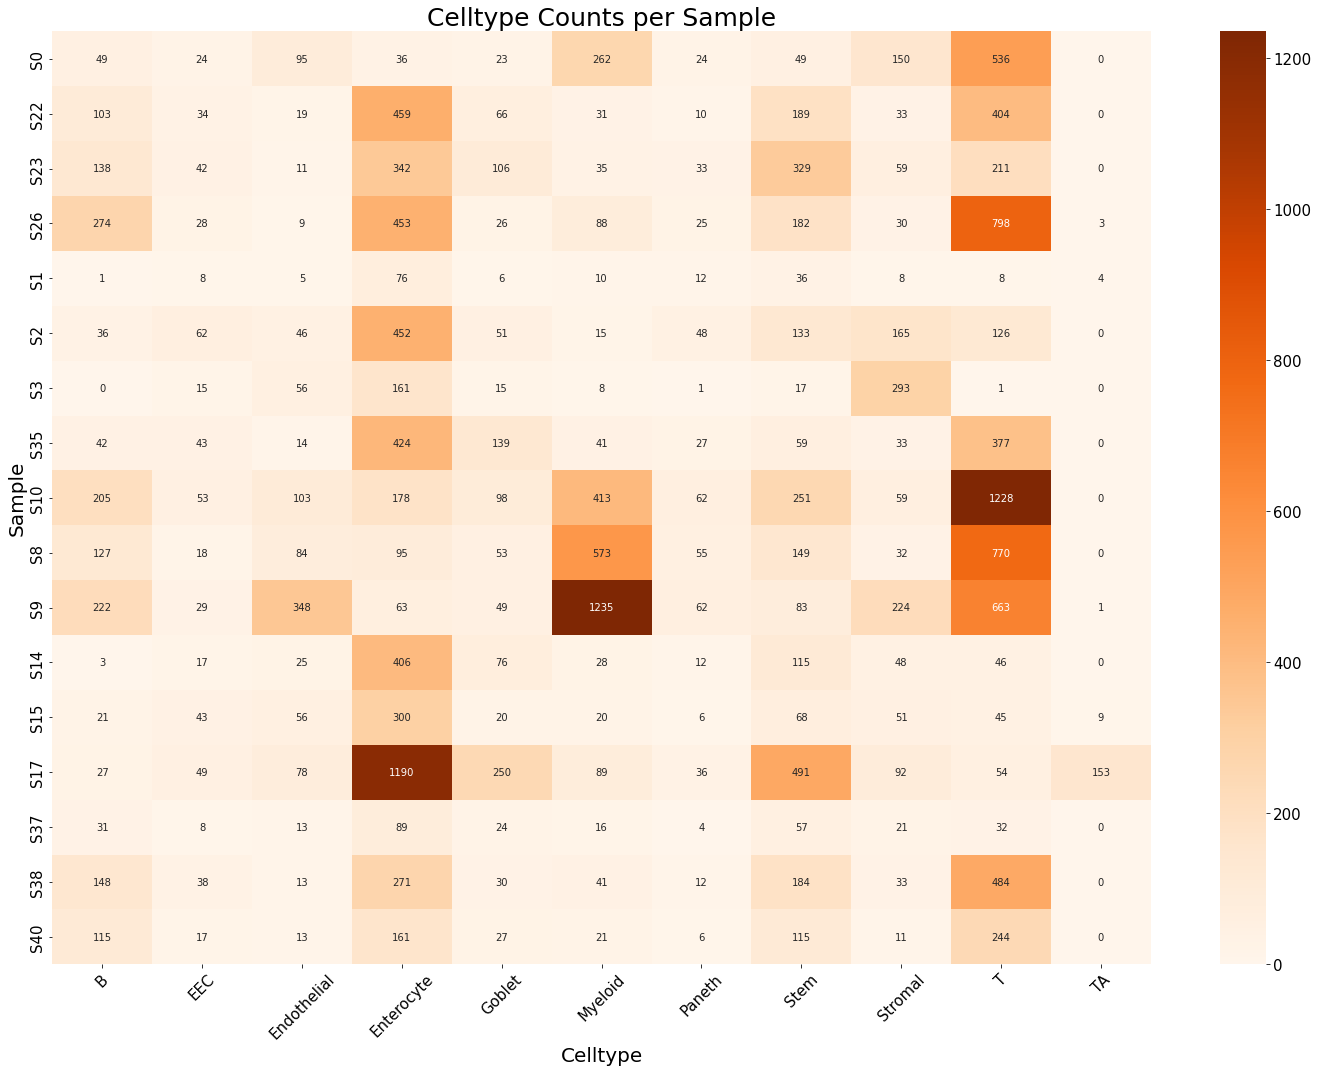

In [66]:
# how many cells and cell type per sample, grouped by day
sample_cluster_counts = metadata_.groupby(['sample', 'Celltype']).size().reset_index(name='count')

# pivot data for heatmap
heatmap_data = sample_cluster_counts.pivot(index='sample', columns='Celltype', values='count').fillna(0)

# Create the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_data.loc[sample_order], annot=True, fmt='.0f', cmap='Oranges')

# Set labels
plt.xlabel('Celltype',fontsize=20)
plt.ylabel('Sample',fontsize=20)
plt.title('Celltype Counts per Sample',fontsize=25)
plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

# Selecting genes to fit

For now, I will fit enterocytes, stem cells, and T cells, for the sample-celltypes that have >40 cells.

I will subset genes based on $Monod's$ default thresholds, while adding the genes the paper mentions as important?


$Monod$ thresholds to filter OUT:

1. $\bar{X}_N \leq 0.01$
2. $\bar{X}_M \leq 0.01$
3. $\textrm{max}(X_N) \leq 3$
4. $\textrm{max}(X_M) \leq 3$
5. $\textrm{max}(X_N) \geq 400$
6. $\textrm{max}(X_M) \geq 400$


In [119]:
gene_id_to_name_map = pd.read_csv('./data/takei/gene_id_to_name_map.csv')

In [152]:
def get_gene_names(adata):
    
    mean_n = nd(adata.layers['unspliced'].mean(axis=0))
    mean_m = nd(adata.layers['unspliced'].mean(axis=0))
    max_n = nd(np.max(adata.layers['spliced'].todense(),axis=0))
    max_m = nd(np.max(adata.layers['unspliced'].todense(),axis=0))
    
    filt = (mean_n>0.01)&(mean_m>0.01)&(3<max_n)&(max_n<400)&(3<max_m)&(max_m<400)
    genes = adata.var.GENE_NAME.values[filt]
    
    return(genes)
    

In [153]:
genes_mentioned = ['Ybx1','Clu','Runx1','Stat3','Hmga1','Olfm4','Prom1','Smoc2',
                   'Hopx','Sox9','Tert','Dclk1','Anxa1','Areg','Lamc2','Cdk4','Top2a','Mki67',
                   'Cd14', 'Ccr2', 'Ly6c2','Cd80', 'Cd206', 'Cd64','F4/80',
                   'Il1a', 'Il1b', 'Il6','Tnf','Icam1','Icam2']

In [163]:
consensus_gene_list = []

for sample in sample_order:
    metadata_sample_ = metadata_[metadata_['sample']==sample]
    adata_ = anndata.read_loom(f'data/lu_radiation/{sample}/counts_unfiltered/adata.loom')
    adata_.obs = adata_.obs.merge(metadata_sample_,on='barcode')
    adata_.layers['unspliced'] = adata_.layers['nascent']
    adata_.layers['spliced'] = adata_.layers['ambiguous']+adata_.layers['mature']
    
    
    adata_.var['ensembl_id_stripped'] = [g.split('.')[0] for g in adata_.var.target_name.values]
    adata_.obs.index = adata_.obs.index.astype(str)
    adata_.var.index = adata_.var.index.astype(str)
    adata_ = adata_[:,adata_.var.ensembl_id_stripped.isin(gene_id_to_name_map.ensembl_id_stripped.values)]
    gene_order = adata_.var.ensembl_id_stripped
    gene_id_to_name_map['ensembl_id_stripped'] = pd.Categorical(gene_id_to_name_map['ensembl_id_stripped'], categories=gene_order, ordered=True)
    gene_id_to_name_map = gene_id_to_name_map.sort_values('ensembl_id_stripped')

    adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values
    adata_.var['GENE_NAME'] = [g.upper() for g in adata_.var.gene_name]

    
    for ct in ['T','Stem','Enterocyte']:
        # save filtered loom files
        print(sample,ct)
        adata_ct_ = adata_[adata_.obs['Celltype']==ct]
        if len(adata_ct_)>40:
            adata_ct_.write_loom(f'data/lu_radiation/{sample}/counts_unfiltered/adata_{ct}.loom')
        
        
        
        

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S0 T
S0 Stem
S0 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S22 T
S22 Stem
S22 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S23 T
S23 Stem
S23 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S26 T
S26 Stem
S26 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S1 T
S1 Stem
S1 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S2 T
S2 Stem
S2 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S3 T
S3 Stem
S3 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S35 T
S35 Stem
S35 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S10 T
S10 Stem
S10 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S8 T
S8 Stem
S8 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S9 T
S9 Stem
S9 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S14 T
S14 Stem
S14 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S15 T
S15 Stem
S15 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S17 T
S17 Stem
S17 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S37 T
S37 Stem
S37 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S38 T
S38 Stem
S38 Enterocyte


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
<ipython-input-163-d93e4c444a0d>:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_.var['gene_name'] = gene_id_to_name_map.gene_name.values


S40 T
S40 Stem
S40 Enterocyte
